In [31]:
%matplotlib inline

In [32]:
from pylab import *
import pylab
import matplotlib as mpl
import numpy
import lnm
from graph import Graph
import ipywidgets as widgets
from IPython.display import display, HTML
mpl.rcParams['savefig.dpi'] = 150
OPTIONS = {'FSM': 'results_fsm.txt',
           'Snake': 'results_snake.txt',
           'Snake New': 'results_snake_03-11-15.txt',
           'Tetris': 'results_tetris.txt',
           'Tetris New': 'results_tetris_03-11-15.txt',
           'Sieve': 'results_sieve.txt',
           'Suffix Tree': 'results_suffixtree.txt',
           'Suffix Tree New': 'results_suffixtree_03-11-15.txt',
           'Synth':'results_synth.txt',
           'Synth New': 'results_synth_03-11-15.txt'}
s = widgets.Dropdown(options=OPTIONS)
all_data_files = ['results_fsm.txt',
                  'results_snake_03-11-15.txt',
                  'results_tetris_03-11-15.txt',
                  'results_sieve.txt',
                  'results_suffixtree_03-11-15.txt',
                  'results_synth_03-11-15.txt']

In [61]:
display(s)

In [62]:
HTML("<h1>Filename: '" + s.value + "'</h1>")

# Select Benchmark:

In [63]:
graph = lnm.read_data(s.value)
variations, data = graph.ungraph()
hidden_untyped = data[0,2]
pycket_untyped = data[0,1]
racket_untyped = data[0,0]
hidden = data[:,2]
pycket = data[:,1]
racket = data[:,0]

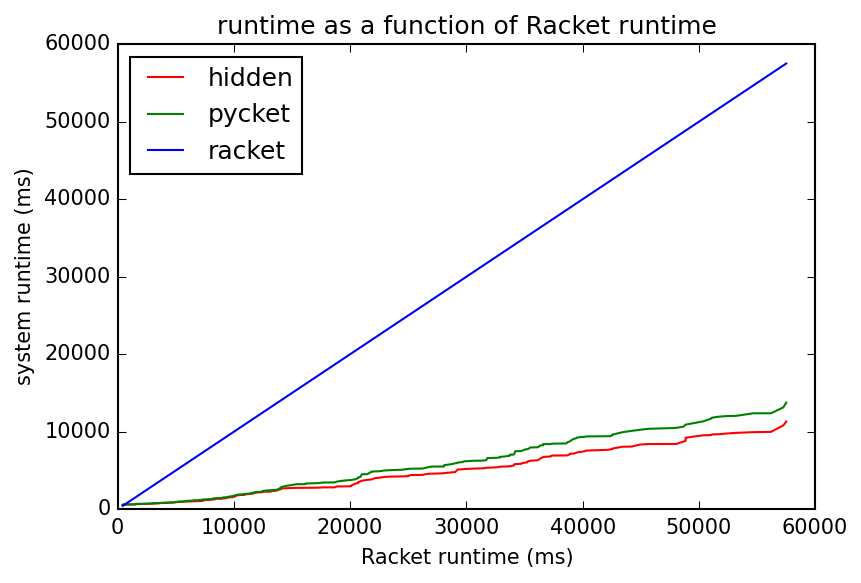

In [64]:
# Runtime of Pycket as a function of Racket
ordered_data = np.copy(data)
ordered_data.sort(axis=0)
ohidden = ordered_data[:,2]
opycket = ordered_data[:,1]
oracket = ordered_data[:,0]
pylab.plot(oracket, ohidden, 'r', label='hidden')
pylab.plot(oracket, opycket, 'g', label='pycket')
pylab.plot(oracket, oracket, 'b', label='racket')
pylab.title('runtime as a function of Racket runtime')
pylab.xlabel('Racket runtime (ms)')
pylab.ylabel('system runtime (ms)')
pylab.legend(loc='best')

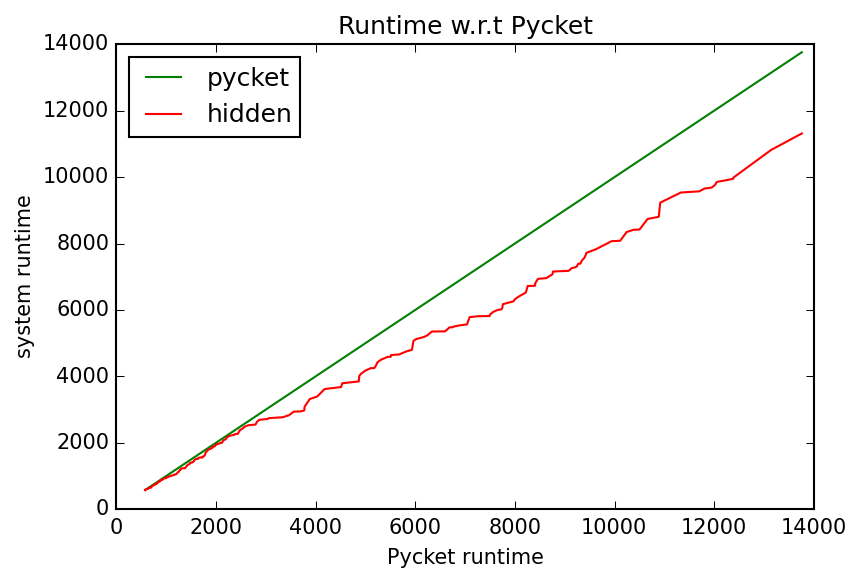

In [65]:
pylab.plot(opycket, opycket, 'g', label='pycket')
pylab.plot(opycket, ohidden, 'r', label='hidden')
pylab.title('Runtime w.r.t Pycket')
pylab.xlabel('Pycket runtime')
pylab.ylabel('system runtime')
pylab.legend(loc='best')

In [106]:
from scipy.stats import cumfreq
from pandas      import DataFrame
from ipy_table   import *

hidden_slowdown = hidden / float(hidden_untyped)
pycket_slowdown = pycket / float(pycket_untyped)
racket_slowdown = racket / float(racket_untyped)

def make_slowdown_data(fname):
    data = np.genfromtxt(fname, usecols=(1,2,3))
    hidden_untyped = float(data[0,2])
    pycket_untyped = float(data[0,1])
    racket_untyped = float(data[0,0])
    hidden = data[:,2]
    pycket = data[:,1]
    racket = data[:,0]
    weights = np.ones(len(hidden)) / float(len(hidden))
    return racket / racket_untyped, pycket / pycket_untyped, hidden / hidden_untyped, weights

def compute_deliverable(data):
    th = sum(data < 3)
    oh = sum(numpy.logical_and(data >= 3, data < 10))
    return [max(data), numpy.mean(data), np.median(data), "%d (%0.2f%%)" % (th, th / float(len(data)) * 100), "%d (%0.2f%%)" % (oh, oh / float(len(data)) * 100)]

def make_deliverable_table(**kwargs):
    lst = [["", "Max overhead", "Mean overhead", "Median overhead", "300-deliverable", "300/1000-usable"]]
    for name, data in kwargs.iteritems():
        lst.append([name] + compute_deliverable(data))
    tbl = make_table(map(list, zip(*lst)))
    apply_theme('basic_both')
    return tbl

def slowdown_cdf(*args, **kwargs):
    weights = kwargs.get('weights', None)
    entries = 0
    for data, color, label in args:
        if weights is not None:
            counts, bin_edges = numpy.histogram(data, weights=weights, bins=len(data))
            entries = np.sum(weights)
        else:
            counts, bin_edges = numpy.histogram(data, bins=len(data))
            entries = len(data)
        cdf = numpy.cumsum(counts)
        pylab.plot(bin_edges[:-1], cdf, color=color, label=label)
    pylab.axvline(3, color='y')
    pylab.axvline(10, color='k')
    pylab.axhline(len(data) * 0.6, color='c', ls='--')
    pylab.xlabel('slowdown factor')
    pylab.xlim((1,20))
    pylab.ylim((0,entries))
    pylab.ylabel('number below')
    pylab.legend(loc='best')
    
def compute_lnm_deliverable(slowdown_graph, L):
    graph = lnm.compute_lnm_times(slowdown_graph, L)
    data = graph.ungraph()[1]
    rs = data[:,0]
    ps = data[:,1]
    hs = data[:,2]
    return rs, ps, hs, make_deliverable_table(racket=rs, pycket=ps,hidden=hs)
    
rs, ps, hs, weights = zip(*[make_slowdown_data(fname) for fname in all_data_files])
rs = reduce(np.append, rs)
ps = reduce(np.append, ps)
hs = reduce(np.append, hs)
weights = reduce(np.append, weights)

# All Data

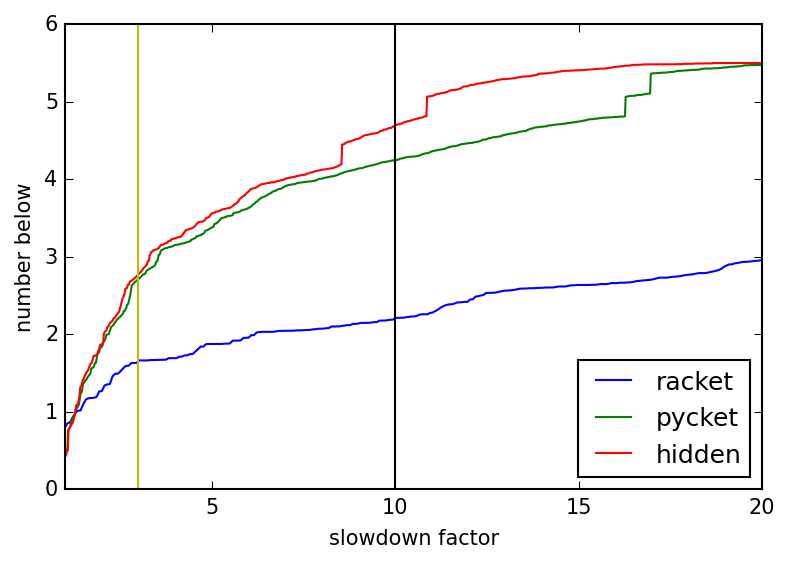

In [107]:
slowdown_cdf((rs, 'b', 'racket'),
             (ps, 'g', 'pycket'),
             (hs, 'r', 'hidden'),
             weights=weights)

# Slowdown Summary Stats

In [68]:
DataFrame({'racket':racket_slowdown, 'pycket':pycket_slowdown, 'hidden':hidden_slowdown}).describe()

,hidden,pycket,racket
count,256.000000,256.000000,256.000000
mean,5.585583,6.507225,33.827300
std,4.387759,5.456118,25.618890
min,0.952145,0.936893,0.760563
25%,2.034241,2.169094,14.306338
50%,3.586634,3.610841,21.426056
75%,8.832096,10.360841,55.867958
max,18.669967,22.265372,101.260563


# Deliverability Stats

## L = 0

In [69]:
slowdown_graph = lnm.fromkeyvals(variations, racket_slowdown, pycket_slowdown, hidden_slowdown)
racket_slowdown0, pycket_slowdown0, hidden_slowdown0, tbl = compute_lnm_deliverable(slowdown_graph, 0)
tbl

,racket,hidden,pycket
Max overhead,101.2606,18.6700,22.2654
Mean overhead,33.8273,5.5856,6.5072
Median overhead,21.4261,3.5866,3.6108
300-deliverable,7 (2.73%),104 (40.62%),101 (39.45%)
300/1000-usable,29 (11.33%),105 (41.02%),86 (33.59%)


## L = 1

In [70]:
racket_slowdown1, pycket_slowdown1, hidden_slowdown1, tbl = compute_lnm_deliverable(slowdown_graph, 1)
tbl

,racket,hidden,pycket
Max overhead,23.1549,4.2096,4.1602
Mean overhead,10.6280,1.8020,1.8720
Median overhead,10.0739,1.5998,1.6748
300-deliverable,35 (13.67%),229 (89.45%),227 (88.67%)
300/1000-usable,91 (35.55%),27 (10.55%),29 (11.33%)


## L = 2

In [71]:
racket_slowdown2, pycket_slowdown2, hidden_slowdown2, tbl = compute_lnm_deliverable(slowdown_graph, 2)
tbl

,racket,hidden,pycket
Max overhead,17.5000,2.6766,2.8673
Mean overhead,5.4733,1.2558,1.2834
Median overhead,4.1479,1.1353,1.1521
300-deliverable,100 (39.06%),256 (100.00%),256 (100.00%)
300/1000-usable,120 (46.88%),0 (0.00%),0 (0.00%)


# Slowdown distribution

## L = 0

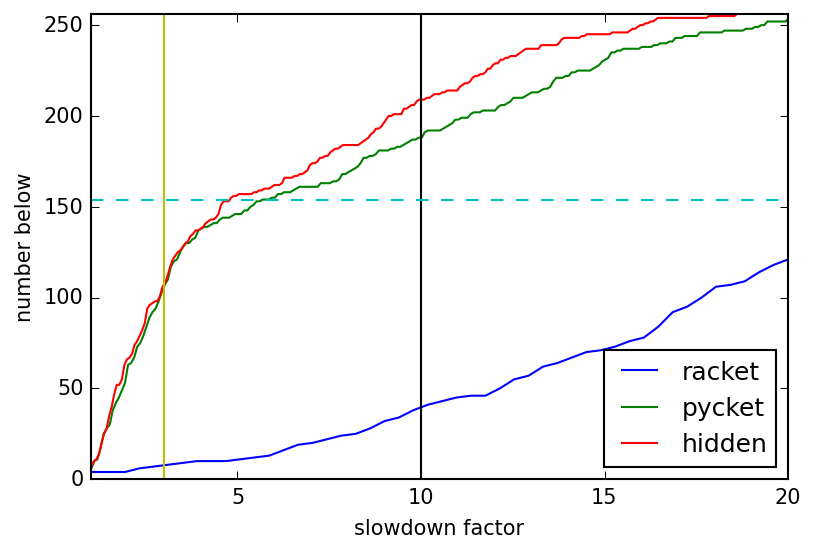

In [72]:
slowdown_cdf((racket_slowdown0, 'b', 'racket'),
             (pycket_slowdown0, 'g', 'pycket'),
             (hidden_slowdown0, 'r', 'hidden'))

## L = 1

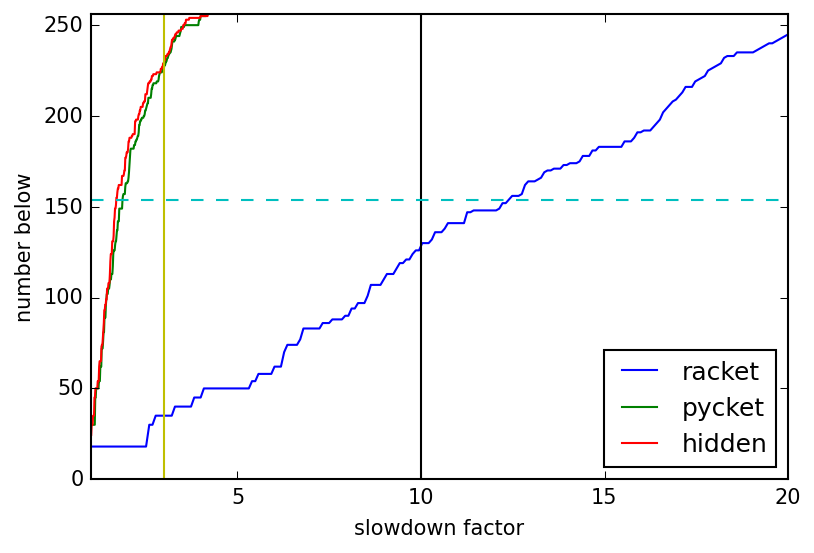

In [73]:
slowdown_cdf((racket_slowdown1, 'b', 'racket'),
             (pycket_slowdown1, 'g', 'pycket'),
             (hidden_slowdown1, 'r', 'hidden'))

## L = 2

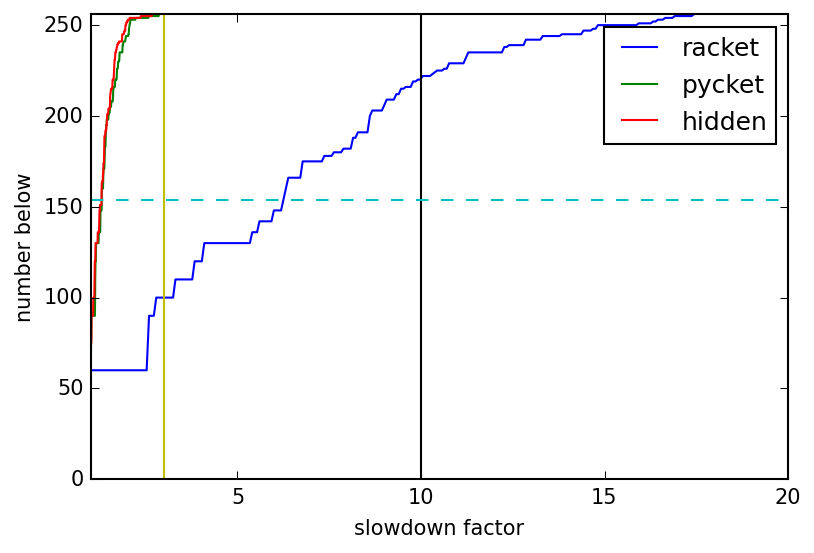

In [74]:
slowdown_cdf((racket_slowdown2, 'b', 'racket'),
             (pycket_slowdown2, 'g', 'pycket'),
             (hidden_slowdown2, 'r', 'hidden'))